Code was modified from [this tutorial](https://dartbrains.org/content/Multivariate_Prediction.html) written by Luke Chang

# First-Level Analysis

An example design matrix is shown below:

<img src="design.png" alt="exemplar design matrix" style="width: 300px;"/>

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.mask import expand_mask
import nibabel as nib
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map, view_img_on_surf
from bids import BIDSLayout, BIDSValidator



base_dir = '/Users/TienTong/Desktop/utdallas_demo/'
data_dir = os.path.join(base_dir, 'data')
layout = BIDSLayout(data_dir, validate=False, derivatives='/Users/TienTong/Desktop/utdallas_demo/derivatives/fmriprep')
firstlevel="/Users/TienTong/Desktop/utdallas_demo/derivatives/firstlevel/"

/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/bids/layout/validation.py:149: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [ ]:
def load_bids_events(layout, subject, run):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    n_tr = nib.load(layout.get(subject=subject, scope='raw', suffix='bold', extension='nii.gz')[0].path).shape[-1]

    onsets = pd.read_csv(layout.get(subject=subject, suffix='events')[run].path, sep='\t')
    onsets = onsets[['onset', 'duration', 'categ']]
    onsets.rename(columns={'onset': 'Onset', 'duration': 'Duration', 'categ': 'Stim'}, inplace=True)

    return onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)

def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

subjects=['01', '02', '03', '04', '05']
fwhm=6

for subject in subjects:
    for run in range(3):
        data = Brain_Data(layout.get(subject=subject, task='em', scope='derivatives', suffix='bold', 
                                     extension='nii.gz', return_type='file')[run])
        ############################### task regressors ##################################
        dm = load_bids_events(layout, subject, run)
        dm_conv = dm.convolve()

        ############################### filter and detrend ###############################
        dm_conv_filt = dm_conv.add_dct_basis(duration=128)
        dm_conv_filt_poly = dm_conv_filt.add_poly()
        dm_conv_filt_poly = dm_conv_filt.add_poly(order=3, include_lower=True)

        ############################# nuisance regressors ################################
        covariates = pd.read_csv(layout.get(subject=subject, scope='derivatives', extension='.tsv')[0].path, sep='\t')
        mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
        mc_cov = make_motion_covariates(mc, 2)

        #################################### despike #####################################
        spikes = data.find_spikes(global_spike_cutoff=2.5, diff_spike_cutoff=2.5)
        spikes.drop(labels='TR', axis=1, inplace=True)

        dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes], axis=1)
        # dm_conv_filt_poly_cov.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

        ############################### smooth then regress ##############################
        smoothed = data.smooth(fwhm=fwhm)
        smoothed.X = dm_conv_filt_poly_cov
        stats = smoothed.regress()

        ############################# save betas ############################
        stats['beta'][0].write(os.path.join(firstlevel,
                                            f'sub-{subject}_betas-run-0{run+1}_face.nii.gz'))
        stats['beta'][1].write(os.path.join(firstlevel,
                                            f'sub-{subject}_betas-run-0{run+1}_scene.nii.gz'))
        stats['beta'][2].write(os.path.join(firstlevel,
                                            f'sub-{subject}_betas-run-0{run+1}_lexdec.nii.gz'))
    

# MVPA

In [2]:
####################################################################
################## LOAD BETAS - Brain Features #####################
####################################################################

firstlevel="/Users/TienTong/Desktop/utdallas_demo/derivatives/firstlevel/"

face_file_list = glob.glob(os.path.join(firstlevel, '*_face.nii.gz'))
face_file_list.sort() 
face = Brain_Data(face_file_list)

scene_file_list = glob.glob(os.path.join(firstlevel, '*_scene.nii.gz'))
scene_file_list.sort() 
scene = Brain_Data(scene_file_list)

lexdec_file_list = glob.glob(os.path.join(firstlevel, '*_lexdec.nii.gz'))
lexdec_file_list.sort() 
lexdec = Brain_Data(lexdec_file_list)

data = face.append(lexdec)

####################################################################
############# LOAD Predicted var Y = task condition ################
####################################################################

Y = pd.DataFrame(np.hstack([np.ones(len(face_file_list)), np.zeros(len(lexdec_file_list))]))
data.Y = Y


sub_list = [os.path.basename(x).split('_')[0] for x in face_file_list]
subject_id = pd.DataFrame(sub_list + sub_list)


# SVM Prediction no mask

overall accuracy: 1.00
overall CV accuracy: 0.53


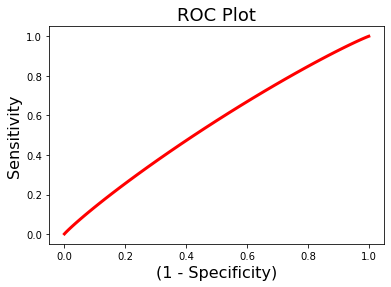

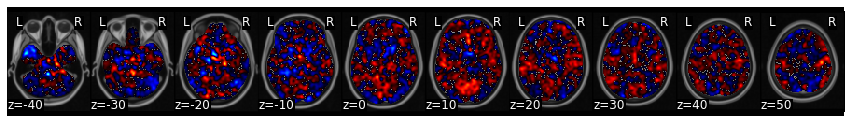

In [3]:
svm_stats = data.predict(algorithm='svm', 
                         cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id}, 
                         **{'kernel':"linear"})

# Ridge Prediction no mask

overall accuracy: 1.00
overall CV accuracy: 0.53


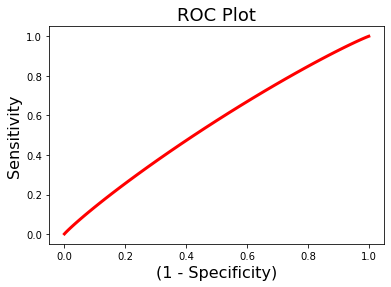

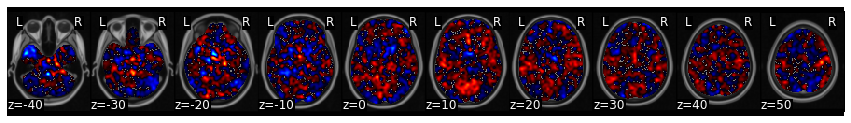

In [4]:
ridge_stats = data.predict(algorithm='ridgeClassifier', 
                        cv_dict={'type': 'kfolds','n_folds': 5,'subject_id':subject_id},
                           **{'alpha':.01})

# SVM Prediction with mask

overall accuracy: 1.00
overall CV accuracy: 0.53


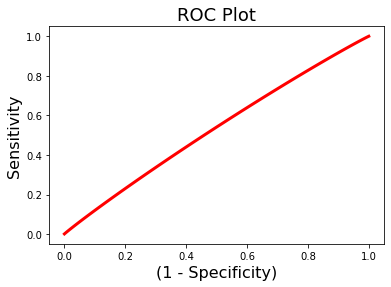

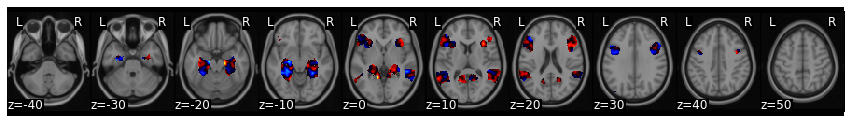

In [5]:
mask = Brain_Data('https://neurovault.org/media/images/8423/k50_2mm.nii.gz')
mask_x = expand_mask(mask)

# more info here: https://neurovault.org/images/395092/
# 1=Fusiform/parahippocampus 
# 5=TPJ posterior supra marginal/angular gyrus 
# 15=TPJ anterior supra marginal gyrus/Parietal operculum 
# 18=Dorsal Anterior Insula 
# 27=Left IFG 
# 28=hippocampus 
# 37=Ventral Anterior Insula
# 44=DLPFC 
# 45=right IFG vlpfc

memory = mask_x[[1,5,15,18,27,28,37,44,45]].sum()
memory = mask_x[[1,5,18,27,28,45]].sum()
data_masked = data.apply_mask(memory)

svm_stats_masked = data_masked.predict(algorithm='svm', cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id}, **{'kernel':"linear"})


# Ridge Prediction with mask

overall accuracy: 1.00
overall CV accuracy: 0.53


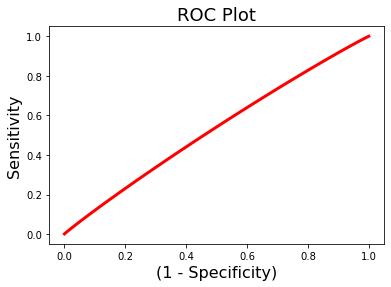

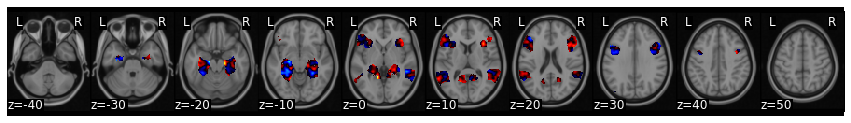

In [6]:
ridge_stats_masked = data_masked.predict(algorithm='ridgeClassifier', 
                        cv_dict={'type': 'kfolds','n_folds': 5,'subject_id':subject_id},
                           **{'alpha':.01})

# First level analysis using Nilearn - not running

Use the Episodic Memory-biased trials only, which included the following conditions:
   * face prospective memory
   * scene prospective memory
   * 2-back lexical decision

Regressor confounds in the first-level analysis: follow [Esteban et al 2020 Nature Protocols](https://www.nature.com/articles/s41596-020-0327-3)
   * DVARS (D, temporal derivative of time courses; VARS, RMS variance over voxels)
   * framewise displacement
   * six anatomical component-based noise correction (CompCor) components 
   * four cosine drift terms
 

In [ ]:
# import os
# from nilearn.glm.first_level import first_level_from_bids

# ####################################################################
# ############################ read BIDSLayout #######################
# ####################################################################

# task_label = 'em'
# space_label = 'MNI152NLin6Asym'
# data_dir='/Users/TienTong/Desktop/utdallas_demo/data'
# derivatives_folder = '/Users/TienTong/Desktop/utdallas_demo/derivatives/fmriprep'
# # confounds_use = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
# confounds_use = ['dvars', 'framewise_displacement'] + \
#         ['a_comp_cor_%02d' % i for i in range(6)] + ['cosine%02d' % i for i in range(4)]

# models, models_run_imgs, models_events, models_confounds = \
#     first_level_from_bids(
#     data_dir, task_label,
#     img_filters=[('desc', 'preproc')],
#     derivatives_folder=derivatives_folder, 
#     smoothing_fwhm=4)

# ####################################################################
# ################ edit confounds list and trial_type ################
# ####################################################################

# for sub in range(5):
#     for run in range(3):
#         models_confounds[sub][run] = models_confounds[sub][run][confounds_use]
#         models_confounds[sub][run].fillna(0, inplace=True)
        
#         events_sub_run = models_events[sub][run]
#         events_sub_run.rename(columns={'categ': 'trial_type'}, inplace=True)
#         models_events[sub][run] = events_sub_run[['onset', 'duration', 'trial_type']]

# ####################################################################
# ############################ Fit GLM ###############################
# ####################################################################

# from nilearn import plotting
# import matplotlib.pyplot as plt
# from nilearn.glm.first_level import FirstLevelModel
# fmri_glm = FirstLevelModel(t_r=2,
#                            high_pass=.008,
#                            smoothing_fwhm=4)

# z_maps = []
# conditions_label = []
# subjects_label = []


# for sub in range(5):
#     for run in range(3):

#         fmri_img = models_run_imgs[sub][run]
#         events = models_events[sub][run]
#         confounds = models_confounds[sub][run]
#         fmri_glm.fit(fmri_img, events, confounds)

#         conditions =['face', 'scene', 'lexdec']
#         for condition_ in conditions:
#             z_maps.append(fmri_glm.compute_contrast(condition_))
#             conditions_label.append(condition_)

# ####################################################################
# ############################ DECODER ###############################
# ####################################################################

# subjects_label = []
# for subject in [1, 2, 3, 4, 5]:
#     for condition in range(3):
#         for run in range(3):
#             subjects_label.append(subject)
# face = pd.get_dummies(conditions_label)['face']

# from nilearn.decoding import Decoder
# from sklearn.model_selection import LeaveOneGroupOut
# cv = LeaveOneGroupOut()

# mask_img = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'
# decoder = Decoder(estimator='svc', mask=mask_img, standardize=True, 
#                   screening_percentile=20, scoring='accuracy', cv=cv)

# # Compute the prediction accuracy for the different folds (i.e. participant)
# decoder.fit(z_maps, face, groups=subjects_label)

# # Print the CV scores
# print(decoder.cv_scores_[1])
# print(np.mean(decoder.cv_scores_[1]))